In [3]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice
from walker import Graphene_Walker
import seaborn as sns
import random

%load_ext autoreload
%matplotlib inline

## Visualize Moire Potential

<a list of 388 text.Text objects>

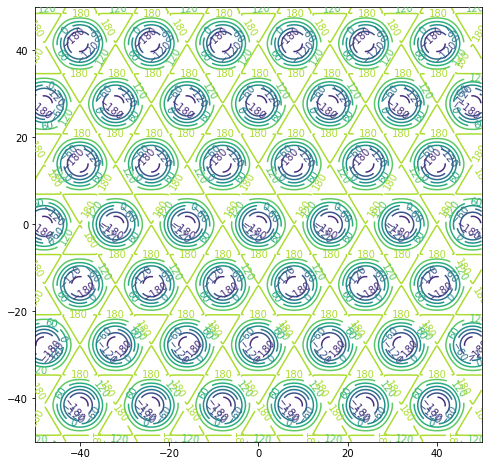

In [2]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.01
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 39.8) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

In [3]:
np.min(Z) * 0.086, np.max(Z) * 0.086

(-19.860796999999998, 19.86079688151187)

## Figure 1

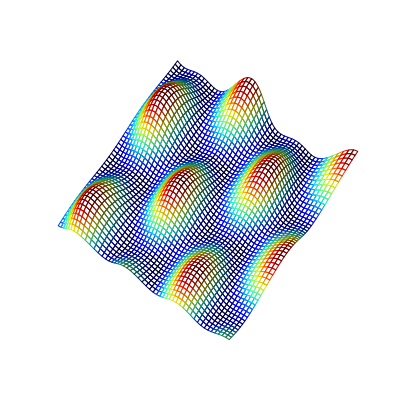

In [4]:
%autoreload 2
from matplotlib import cm
import seaborn as sns

delta = 0.005
x = np.arange(0, 28, delta)
y = np.arange(0, 48, delta)
X, Y = np.meshgrid(x, y)
lattice = Triangular_Lattice(16, 39.8)
Z = lattice.U(X, Y)

# Normalize the colors based on Z value
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet_r(norm(Z))


fig= plt.figure(figsize = (7,7))

ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=True)
surf.set_facecolor((0,0,0,0))


ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')

ax.view_init(-98, -215)
# plt.savefig('./moire_jet.pdf',dpi=300)

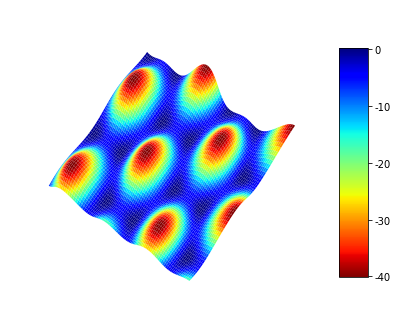

In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig= plt.figure(figsize = (7,7))
delta = 0.5
x = np.arange(0, 28, delta)
y = np.arange(0, 48, delta)
X, Y = np.meshgrid(x, y)
lattice = Triangular_Lattice(16, 39.8)
Z = lattice.U(X, Y)*0.088
ax = plt.axes(projection='3d')
surfplot = ax.plot_surface(X, Y, Z, cmap="jet_r", lw=0.5, rstride=1, cstride=1, alpha=1, shade=True) #cmap="gist_heat_r"
surfplot.set_facecolor((0,0,0,0))
# ax.contour(X, Y, Z, 10, offset=-1, lw=3, colors="k", linestyles="solid", alpha=0.5)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')
cbar = plt.colorbar(surfplot, shrink=0.6 , aspect=8, ticks=[-20, -10, 0, 10, 20])
cbar.ax.set_yticklabels(['-40','-30','-20', '-10', '0'])  # vertically oriented colorbar
ax.view_init(-98, -215)
plt.show()
# fig.savefig('./moire_jet_colorbar.pdf',dpi=300)

21 done
41 done
CPU times: user 28.4 s, sys: 788 ms, total: 29.1 s
Wall time: 28.2 s


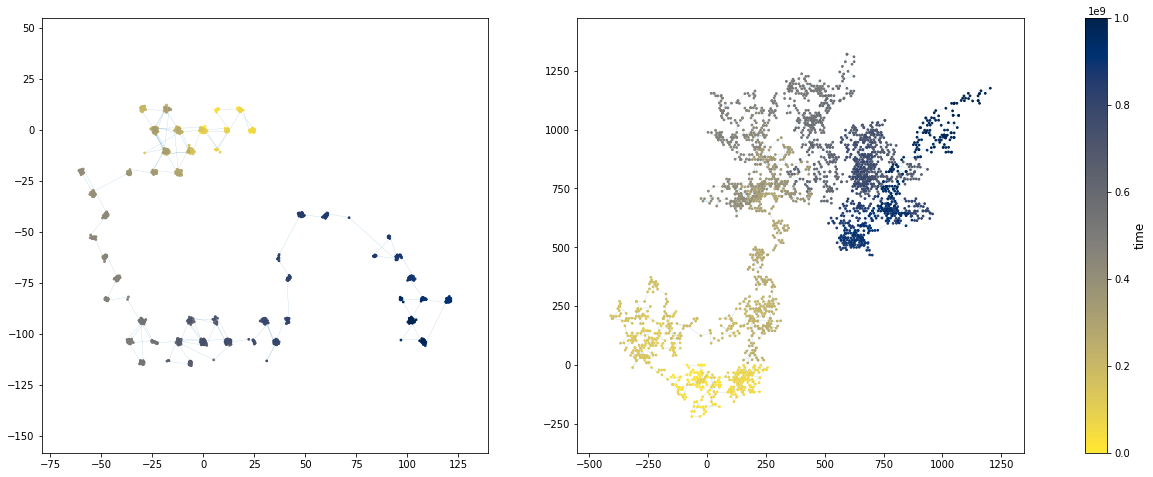

In [6]:
%%time
from lattice import Triangular_Lattice
from walker import Graphene_Walker
np.random.seed(123)
random.seed(123)
barrier = 39.8
lattice = 12
moire1 = Triangular_Lattice(lattice, barrier) # 16nm lattice constant, 1meV energy amplitude
walkers1 = Graphene_Walker(0.246, 21) # 2.46 Angstrom lattice, 10 Kelvin
tracks1 = walkers1.get_tracks(moire1, nsteps=3000, njumps=100000, nparticles=1, endT=1e9)
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

tracks1 = tracks1[tracks1['particle'] == 0]
x, y, t = tracks1['x'], tracks1['y'], tracks1['time']
ax[0].plot(x,y,lw=.1, zorder=0)
tmax = t.max()
scat = ax[0].scatter(x, y, c=t, cmap = 'cividis_r', vmin=0, vmax=tmax,
                      s=3, zorder=1)

cbar = fig.colorbar(scat, ax=ax).set_label(label=r'time', fontsize=12)
# ax[0].set_xlim((-65,95))
# ax[0].set_ylim((-95,65))
ax[0].set_aspect('equal', 'datalim')
ax[0].margins(0.1)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_aspect('equal')

moire2 = Triangular_Lattice(lattice, barrier) # 16nm lattice constant, 1meV energy amplitude
walkers2 = Graphene_Walker(0.246, 41) # 2.46 Angstrom lattice, 10 Kelvin
tracks2 = walkers2.get_tracks(moire2, nsteps=3000, njumps=100000, nparticles=1, endT=1e9)

tracks2 = tracks2[tracks2['particle'] == 0]
x, y, t = tracks2['x'], tracks2['y'], tracks2['time']
ax[1].plot(x,y,lw=.1, zorder=0)
tmax = t.max()
scat = ax[1].scatter(x, y, c=t, cmap ='cividis_r', vmin=0, vmax=tmax,
                      s=3, zorder=1)
# ax[1].set_xlim((-65,95))
# ax[1].set_ylim((-95,65))
ax[1].set_aspect('equal', 'datalim')
ax[1].margins(0.1)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_aspect('equal')
fig.savefig('sample_traj_{}meV.pdf'.format(barrier),dpi=200, bbox_inches='tight')
fig.savefig('sample_traj_{}meV.png'.format(barrier),dpi=300, bbox_inches='tight')

# Wait Time Tail

In [36]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product


temps =[20, 22, 24, 26, 28, 30, 32]
lattice_constants = [16]
barrier = 39.8

kws = {
    'njumps' : 1000000, 
    'nparticles' : 100, 
    'init' : 1,
}

def get_waits(m_lattice, temperature, total_particles=1000, **kws):
    random.seed(1)
    np.random.seed(1)
    moire = Triangular_Lattice(m_lattice, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    tracks = walkers.walk(**kws)
    waits = walkers.get_waits(moire, tracks, **kws).flatten()
    return waits
result = Parallel(n_jobs=-1, prefer='threads')(delayed(get_waits)(m_lattice, temperature, **kws) for m_lattice, temperature in tqdm(product(lattice_constants, temps)))
print('done')

7it [00:00, 419.50it/s]


32 done
done
CPU times: user 3min 7s, sys: 20.7 s, total: 3min 28s
Wall time: 1min 11s


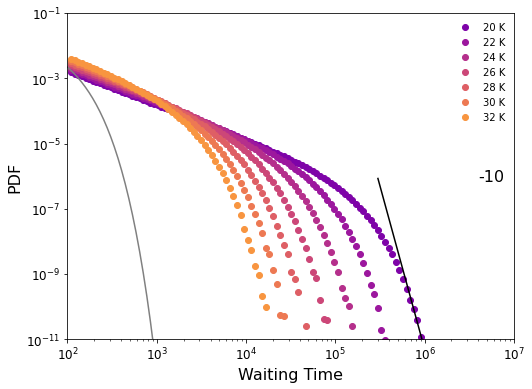

In [38]:
import scipy.stats
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = plt.cm.plasma(np.linspace(0.25, 0.75, len(temps)))
# waits = np.array(result).reshape((len(lattice_constants), len(temps), 50000050))
waits = np.array(result).reshape((len(lattice_constants), len(temps), 100000100))
for i, T in enumerate(temps):
    yy, xx = np.histogram(waits[0, i] , np.logspace(2, np.log10(1e6), 100), density=True)
    xmax = np.max(xx)
    ax.scatter(xx[1:-1], yy[1:], color=col[i], label='{} K'.format(T))



mu, loc = scipy.stats.expon.fit(waits[0, i])
best_fit_line = scipy.stats.expon.pdf(xx, mu, loc)
plt.plot(xx, best_fit_line,c='gray')

# xrng = np.linspace(1e3, 2e3, 100)
# ax.plot(xrng, 1e39*xrng**(-15), color='k')
xrange = np.linspace(3e5, 1.4e6, 100)
ax.plot(xrange, 0.5e49*xrange**(-10), color='k')

ax.set_ylim(1e-11, 1e-1)
ax.set_xlim(1e2, 1e7)


ax.text(0.95, 0.5,'-10', fontsize=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)
ax.legend(frameon=False)


plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
# plt.title('Wait Times Probability Density')
plt.xlabel('Waiting Time',fontsize=16)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ylabel('PDF',fontsize=16)
fig.savefig('./waitingtime_dist.pdf', dpi=300, bbox_inches='tight')

## Distribution of Displacement

In [31]:
def plot_hist_dots(ax, x,y, xmin="", xmax="", title="", text="", log=False, color='gray',legend=""):


    dx1 = np.concatenate([np.diff(x),np.diff(y)])

    yy, xx = np.histogram(dx1, np.arange(-80 - 4, 4 + 80, 8), density=True)
    
#     mu, loc = scipy.stats.norm.fit(dx1)
#     best_fit_line = scipy.stats.norm.pdf(xx, mu, loc)
    
    
    xmax = np.max(xx[xx>0])
    xmin = np.min(xx[xx>0])

    ymin = np.min(yy[yy>0])
    ymax = np.max(yy[yy>0])
    
    xx = xx[:-1] + (xx[1] - xx[0])/2
    ax.scatter(xx, yy, c=color, marker='o', s=40,label=legend)
    ax.plot(xx, yy, c=color, linewidth=1)
#     ax.plot(xx, best_fit_line[1:],c='gray')
    ax.set_xlabel(r'Displacement',fontsize=16)
    ax.set_ylabel(r'PDF',fontsize=16)
    ax.margins(0.1)
    ax.set_ylim(ymin,ymax+3)
#     ax.set_xlim(1,10)
    ax.legend(frameon=False)

    if log:
        ax.set_yscale('log')
#         ax.set_xscale('log')
    return ax

32 done
20 done
22 done
24 done
26 done
28 done
30 done


0it [00:00, ?it/s]*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
1it [00:06,  6.50s/it]*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2it [00:10,  5.32s/it]*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for

CPU times: user 32.2 s, sys: 1.55 s, total: 33.8 s
Wall time: 54min


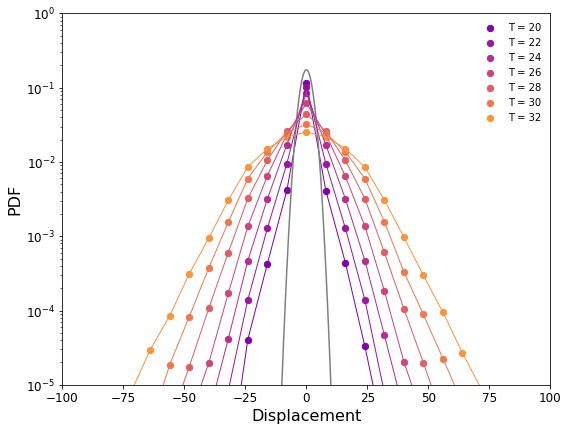

In [34]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
import seaborn as sns
import scipy.stats


temperatures = np.arange(20, 34, 2)
periodicity = [8]
barrier = 39.8
c = plt.cm.plasma(np.linspace(0.25, 0.75, len(temperatures)))
nsteps=300
def get_tracks(period, barrier, temperature):
    random.seed(1)
    np.random.seed(1)
    moire = Triangular_Lattice(period, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    return walkers.get_tracks(moire, nsteps=100, njumps=100000, nparticles=2000, endT=1e8, init=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i,period in enumerate(periodicity):
    result = Parallel(n_jobs=-1)(delayed(get_tracks)(period, barrier, temperature) for temperature in temperatures) 
    for j,(tracks,temp) in tqdm(enumerate(zip(result, temperatures))):

       ## generate tracks at that temperature
        random.seed(1)
        np.random.seed(1)
        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)
        title ='T = {:.0f}'.format(temp)
        ax = plot_hist_dots(ax, x,y,log=True, color=c[2*i+j], legend =title)
        if temp == temperatures[0]:
            dx1 = np.concatenate([np.diff(x),np.diff(y)])
            yy, xx = np.histogram(dx1, 100, density=True)

            mu, loc = scipy.stats.norm.fit(dx1)
            best_fit_line = scipy.stats.norm.pdf(xx, mu, loc)
            ax.plot(xx, best_fit_line,c='gray')
        fig.tight_layout()
        ax.set_ylim(1e-5,1)
        ax.set_xlim(-100,100)
        plt.xticks(fontsize= 12)
        plt.yticks(fontsize= 12)
fig.savefig('./displacement_dist_lin.pdf', dpi=300, bbox_inches='tight')

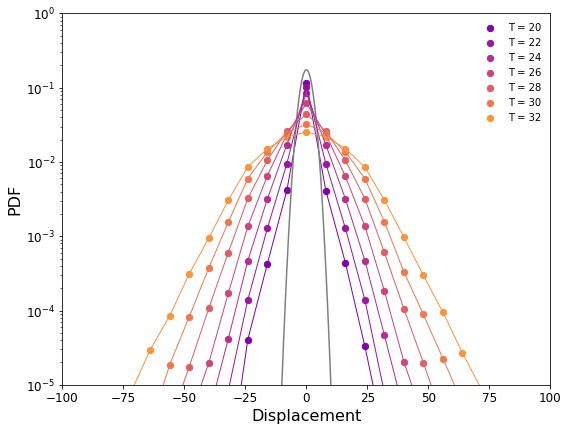

In [35]:
ax.set_ylim(1e-5,1)
ax.set_xlim(-100,100)
fig

## Temperature Plots (figure 3)

Restart and run imports to have enough RAM for this section

In [39]:
%%time
from utils import *
from walker import Graphene_Walker
from joblib import Parallel, delayed
from tqdm import tqdm
import pdb


from tensorflow.keras.models import Sequential, load_model, Model

np.random.seed(0)
random.seed(0)

temperatures = np.arange(20, 34, 1)
periodicity = [4, 8, 12, 16]
# temperatures = [21]
# periodicity = [12]
barrier = 39.8
nsteps = 300

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
avg_period_temp_values = []
std_period_temp_values = []
alpha_period_temp_values = []
astd_period_temp_values = []

fbm_alpha = net_file = load_model('models/{}-H-estimate.h5'.format(nsteps))
ctrw_alpha = net_file = load_model('models/model-alphaCTRW-estimate_{}.h5'.format(nsteps))
class_model = net_file = load_model( 'models/{}_new_model.h5'.format(nsteps))

def get_tracks(period, barrier, temperature):
    moire = Triangular_Lattice(period, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    return walkers.get_tracks(moire, nsteps=nsteps, njumps=100000, nparticles=1000, endT=1e8)

for i, period in enumerate(periodicity):
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    avg_all_temp_values = []
    std_all_temp_values = []
    alpha_all_temp_values = []
    astd_all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    result = Parallel(n_jobs=-1)(delayed(get_tracks)(period, barrier, temperature) for temperature in temperatures)
    for tracks in tqdm(result):

        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            if not tracks[tracks['particle'] == particle][['x', 'y']].isna().any().any(): # check for nans
                x.append(np.array(tracks[tracks['particle'] == particle]['x']))
                y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / nsteps)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx, steps=nsteps, model=class_model) #values is the probability value, prediction is the predicted class (0,1,2)

        alphas = alpha_on_real(temp_dx, temp_predictions, fbm_alpha, ctrw_alpha, steps=nsteps)
        
        all_temp_activations.append(get_activations(temp_dx, steps=nsteps))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))
        
        avg_temp_values = np.mean(temp_values, axis=0) #average probability over all particles from that temp and period
        std_temp_values = np.std(temp_values, axis=0) #std of probability over all particles from that temp and period
        alpha_temp_values = np.mean(alphas, axis=0) #average alpha over all particles from that temp and period
        astd_temp_values = np.std(alphas) #std of alpha over all particles from that temp and period

        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
        avg_all_temp_values.append(avg_temp_values)
        std_all_temp_values.append(std_temp_values)
        alpha_all_temp_values.append(alpha_temp_values)
        astd_all_temp_values.append(astd_temp_values)
        

#     period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    avg_period_temp_values.append(avg_all_temp_values)
    std_period_temp_values.append(std_all_temp_values)
    alpha_period_temp_values.append(alpha_all_temp_values)
    astd_period_temp_values.append(astd_all_temp_values)

# all_temp_activations = np.array(all_temp_activations)

2021-11-15 03:02:00.768372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 03:02:00.768446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-15 03:02:05.132295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-15 03:02:05.132394: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-15 03:02:05.132464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nuke): /proc/driver/nvidia/version does not exist


26 done
27 done
20 done
28 done
22 done
29 done
21 done
30 done
23 done
31 done


  0%|                                                  | 0/14 [00:00<?, ?it/s]2021-11-15 03:26:49.810782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


24 done
32 done


/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
  7%|██▉                                      | 1/14 [03:28<45:15, 208.90s/it]

25 done
33 done


100%|████████████████████████████████████████| 14/14 [35:36<00:00, 152.57s/it]


26 done
27 done
20 done
28 done
21 done
29 done
22 done
30 done
23 done
31 done
24 done
32 done


  7%|██▉                                      | 1/14 [03:28<45:04, 208.05s/it]

25 done
33 done


100%|████████████████████████████████████████| 14/14 [39:31<00:00, 169.39s/it]


26 done
27 done
20 done
28 done
21 done
29 done
22 done
30 done
23 done
31 done
24 done
32 done


  7%|██▉                                      | 1/14 [03:31<45:46, 211.28s/it]

25 done
33 done


100%|████████████████████████████████████████| 14/14 [42:34<00:00, 182.44s/it]


26 done
27 done
20 done
28 done
21 done
29 done
22 done
30 done
23 done
31 done
24 done
32 done


  7%|██▉                                      | 1/14 [03:36<46:49, 216.15s/it]

25 done
33 done


100%|████████████████████████████████████████| 14/14 [45:25<00:00, 194.71s/it]

CPU times: user 3h 3min 9s, sys: 8min 20s, total: 3h 11min 29s
Wall time: 6h 10min 19s


In [40]:
mtx = np.asarray(avg_period_temp_values)
err = np.asarray(std_period_temp_values)
amtx = np.asarray(alpha_period_temp_values)
aerr = np.asarray(astd_period_temp_values)

(-0.1, 1.1)

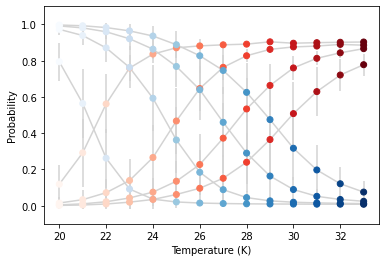

In [41]:
for ind,per in enumerate(periodicity[0:4]):
    x = temperatures
    plt.errorbar(x,mtx[ind,:,2],err[ind,:,2],c='lightgray',zorder=0)
    plt.errorbar(x,mtx[ind,:,1],err[ind,:,2],c='lightgray',zorder=0)
    plt.scatter(x,mtx[ind,:,2],c=x,cmap=plt.cm.Blues,label='ctrw probability')
    plt.scatter(x,mtx[ind,:,1],c=x,cmap=plt.cm.Reds,label='Brownian probability')
plt.xlabel("Temperature (K)")
plt.ylabel("Probability")
plt.ylim((-0.1,1.1))
# plt.legend()
# plt.savefig('./probabilityvaluesMoNet-400part_19-8barrier_300steps_endTscaled.png', dpi=300, bbox_inches='tight')

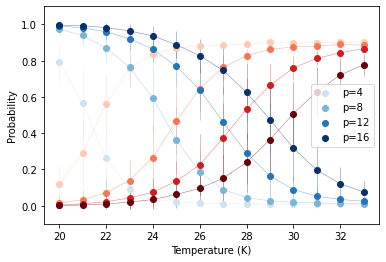

In [42]:
import matplotlib.pylab as pl
colors_ctrw = pl.cm.Blues(np.linspace(0.2,1,4))
colors_brown = pl.cm.Reds(np.linspace(0.2,1,4))
for ind,per in enumerate(periodicity):
    x = temperatures
    label_p = 'p='+str(per)
    plt.errorbar(x,mtx[ind,:,2],err[ind,:,2],color=colors_ctrw[ind],zorder=0,linewidth=0.5,alpha=0.6)
    plt.errorbar(x,mtx[ind,:,1],err[ind,:,2],color=colors_brown[ind],zorder=0,linewidth=0.5,alpha=0.6)
    plt.scatter(x,mtx[ind,:,2],color=colors_ctrw[ind], label=label_p)
    plt.scatter(x,mtx[ind,:,1],color=colors_brown[ind])
plt.xlabel("Temperature (K)")
plt.ylabel("Probability")
plt.ylim((-0.1,1.1))
plt.legend()
plt.savefig('./probabilityvaluesMoNet-400part_{:.2f}barrier_300steps_endTscaled.png'.format(barrier), dpi=300, bbox_inches='tight')

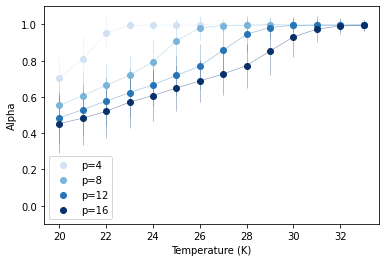

In [43]:
import matplotlib.pylab as pl
colors_ctrw = pl.cm.Blues(np.linspace(0.2,1,4))
for ind,per in enumerate(periodicity):
    x = temperatures
    label_p = 'p='+str(per)
    plt.errorbar(x,amtx[ind,:, 0],aerr[ind,:],color=colors_ctrw[ind],zorder=0,linewidth=0.5,alpha=0.6)
    plt.scatter(x,amtx[ind,:, 0],color=colors_ctrw[ind], label=label_p)
plt.xlabel("Temperature (K)")
plt.ylabel("Alpha")
plt.ylim((-0.1,1.1))
plt.legend()
plt.savefig('./alphavaluesMoNet-400part_{:.2f}barrier_300steps_endTscaled.png'.format(barrier), dpi=300, bbox_inches='tight')

## UMap (restart the notebook before running this section, names are repeated from previpus section)

In [2]:
%autoreload 2
from utils import *
from walker import Graphene_Walker
import random
from joblib import Parallel, delayed

2021-11-12 00:01:23.875873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 00:01:23.875925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
%%time
temperatures = [20, 30, 32]
periodicity = [16]
barrier = 39.8
nsteps = 300

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
avg_period_temp_values = []
std_period_temp_values = []
alpha_period_temp_values = []
astd_period_temp_values = []
 
fbm_alpha = net_file = load_model('models/{}-H-estimate.h5'.format(nsteps))
ctrw_alpha = net_file = load_model('models/model-alphaCTRW-estimate_{}.h5'.format(nsteps))
class_model = net_file = load_model( 'models/{}_new_model.h5'.format(nsteps))

def get_tracks(period, barrier, temperature):
    moire = Triangular_Lattice(period, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    return walkers.get_tracks(moire, nsteps=300, njumps=1000000, nparticles=300, endT=1e8, init=0)

random.seed(0)
np.random.seed(0)
for period in periodicity:
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    avg_all_temp_values = []
    std_all_temp_values = []
    alpha_all_temp_values = []
    astd_all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    result = Parallel(n_jobs=-1)(delayed(get_tracks)(period, barrier, temperature) for temperature in temperatures)
    for tracks, temp in zip(result, temperatures):
        print(period, temp)
        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)

#         print(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / nsteps)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx, steps=nsteps, model=class_model) #values is the probability value, prediction is the predicted class (0,1,2)
        alphas = alpha_on_real(temp_dx, temp_predictions, fbm_alpha, ctrw_alpha, steps=nsteps)
        all_temp_activations.append(get_activations(temp_dx, steps=nsteps))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))

        
        avg_temp_values = np.mean(temp_values, axis=0) #average probability over all particles from that temp and period
        std_temp_values = np.std(temp_values, axis=0) #std of probability over all particles from that temp and period
        alpha_temp_values = np.mean(alphas, axis=0) #average alpha over all particles from that temp and period
        astd_temp_values = np.std(alphas) #std of alpha over all particles from that temp and period


        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
        avg_all_temp_values.append(avg_temp_values)
        std_all_temp_values.append(std_temp_values)
        alpha_all_temp_values.append(alpha_temp_values)
        astd_all_temp_values.append(astd_temp_values)
        

    period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    avg_period_temp_values.append(avg_all_temp_values)
    std_period_temp_values.append(std_all_temp_values)
    alpha_period_temp_values.append(alpha_all_temp_values)
    astd_period_temp_values.append(astd_all_temp_values)

all_temp_activations = np.array(all_temp_activations)

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def manifold(dx, predictions, s=30, ax=None, markers = ["o",">","s"], colors="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="umap"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=0).fit_transform(dx)
    elif embedding_name == 'umap':
        print(dx.shape)
        num_temps = dx.shape[0]
        dx_scaled = np.concatenate([StandardScaler().fit_transform(x) for x in dx], axis = 0)

        random.seed(0)
        np.random.seed(0)
        embedded_dx = UMAP(random_state=0).fit_transform(dx_scaled)
        
        interval_size = len(embedded_dx) // num_temps
        fbm_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 0]) for i in range(num_temps)]
        brownian_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 1]) for i in range(num_temps)]
        ctrw_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 2]) for i in range(num_temps)]
        
        fbm = None
        ctrw = None
        brownian = None
        plt_list = []
        plt_names = []
        if ax is None:
            ax = plt.axes()
            ax.figure.set_size_inches(8,6)
        
        for i in range(num_temps):
            if len(fbm_points[i]) != 0:
                fbm = ax.scatter(fbm_points[i][:,0], fbm_points[i][:,1], s=s, c=colors[i],marker=markers[0], alpha=0.5, edgecolor=None)
#                 plt_names.append("fbm")
                
            if len(ctrw_points[i]) != 0:
                ctrw = ax.scatter(ctrw_points[i][:,0], ctrw_points[i][:,1], s=s, c=colors[i], marker=markers[0], alpha=0.5, edgecolor=None)
                if i == 0:
                    temps = [20, 27, 34]
                    plt_list.append(ctrw)
                    plt_names.append(f"{temps[i]}K")
#                 plt_names.append("ctrw")
        
            if len(brownian_points[i]) != 0:
                temps = [20, 27, 34]
                print(len(brownian_points[i]))
                brownian = ax.scatter(brownian_points[i][:,0], brownian_points[i][:,1], s=s, c=colors[i], marker=markers[0], alpha=0.5, edgecolor=None)
                plt_list.append(brownian)
                plt_names.append(f"{temps[i]}K")
#                 plt_names.append("brownian")

#         plt_list.append(fbm)
#         plt_names.append("fbm")
        
#         plt_list.append(ctrw)
#         plt_names.append("ctrw")
        
#         plt_list.append(brownian)
#         plt_names.append("brownian")

        plt.legend(plt_list, plt_names, frameon=False)
#         plt.xticks([-5,0,5,10],fontsize= 12)
#         plt.yticks([0,5,10],fontsize= 12)
        plt.xticks([])
        plt.yticks([])
#         ax.set_xlabel('UMAP 1', fontsize=16)
#         ax.set_ylabel('UMAP 2', fontsize=16)
        plt.savefig("UMAP_temp.pdf", dpi=300, bbox_inches='tight')
        
        return ctrw, ax
    else:
        raise NotImplementedError


In [ ]:
np.array(period_temp_activations[0])[:].shape

In [ ]:
import seaborn as sns
marker_size = 80
colors = plt.cm.plasma(np.linspace(0.25, 0.75, 3))

manifold(np.array(period_temp_activations[0])[:].squeeze(), np.concatenate(period_temp_predictions[0][:]), s = marker_size, colors=colors)

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def manifold2(dx, predictions, s=30, ax=None, markers = ["o",">","s"], colors="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="umap"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    elif embedding_name == 'umap':
        num_temps = dx.shape[0]
        random.seed(1)
        np.random.seed(1)
        dx_scaled = np.concatenate([StandardScaler().fit_transform(x) for x in dx], axis = 0)
        embedded_dx = UMAP(random_state=12345).fit_transform(dx_scaled)
        
        interval_size = len(embedded_dx) // num_temps
        fbm_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 0]) for i in range(num_temps)]
        ctrw_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 2]) for i in range(num_temps)]
        brownian_points = [np.array([x for idx, x in enumerate(embedded_dx[i * interval_size: (i + 1) * interval_size]) 
                                if predictions[idx + i * interval_size][1] == 1]) for i in range(num_temps)]

        fbm = None
        ctrw = None
        brownian = None
        plt_list = []
        plt_names = []
        if ax is None:
            ax = plt.axes()
            ax.figure.set_size_inches(8,6)
        
        for i in range(num_temps):
#             if len(fbm_points[i]) != 0:
#             fbm = ax.scatter(fbm_points[i][:,0], fbm_points[i][:,1], s=s, c=colors[2], alpha=0.5, marker=markers[0], edgecolors=None)
            
            if len(ctrw_points[i]) != 0:
                ctrw = ax.scatter(ctrw_points[i][:,0], ctrw_points[i][:,1], s=s, c=colors[0], alpha = 0.7, marker=markers[0], edgecolors=None) #, label = "CTRW"
        
            if len(brownian_points[i]) != 0:
                brownian = ax.scatter(brownian_points[i][:,0], brownian_points[i][:,1], s=s, c=colors[1], alpha=0.7, marker=markers[0],edgecolors=None) #, label ="Brownian"

#         plt_list.append(fbm)
#         plt_names.append("FBM")
        
        plt_list.append(ctrw)
        plt_names.append("CTRW")
        
        plt_list.append(brownian)
        plt_names.append("Brownian")
        
        plt.legend(plt_list, plt_names, frameon=False)
#         plt.xticks([-5,0,5,10],fontsize= 12)
#         plt.yticks([0,5,10],fontsize= 12)
        plt.xticks([])
        plt.yticks([])
#         ax.set_xlabel('UMAP 1', fontsize=16)
#         ax.set_ylabel('UMAP 2', fontsize=16)
        plt.box('off')
        plt.savefig("UMAP_class.pdf", dpi=300, bbox_inches='tight')
        return ctrw, ax
    else:
        raise NotImplementedError



In [ ]:
import seaborn as sns
marker_size = 80
colors = sns.color_palette("Set2",3)

manifold2(np.array(period_temp_activations[0])[:].squeeze(), np.concatenate(period_temp_predictions[0][:]), s = marker_size, colors=colors)



In [28]:
all_data = [period_temp_activations, period_temp_predictions, period_temp_values, period_num_fbm, period_num_brownian,
            period_num_ctrw, avg_period_temp_values, std_period_temp_values, alpha_period_temp_values, astd_period_temp_values]

In [ ]:
import pickle
with open("all_data.pkl", "wb") as f:
    pickle.dump(all_data, f)